# Complex Sentiment Index :: creation of indices

In [1]:
coins = [
#     'BTC',   # 1
    'ETH',   # 2
#     'BNB',   # 3
#     'DOT',   # 4
#     'SOL',   # 5
#     'LUNA',  # 6
#     'ADA',   # 7
#     'CRO',   # 8
#     'AXS',   # 9
#     'SAND',  # 10
#     'DOGE',  # 11
#     'SHIB',  # 12
#     'MATIC', # 13
]

In [2]:
import glob
import pandas as pd

dataset = '004'

dfs = {}

for coin in coins:
    df_arr = []
    for filepath in glob.iglob(f"tweets/{dataset}/{coin}*.csv"):
        try:
            df_arr.append(pd.read_csv(filepath, converters={'orig_id': str}, lineterminator='\n'))
        except Exception as e:
            print(f"Error in {filepath}: {e}")
    dfs[coin] = pd.concat(df_arr)

ValueError: No objects to concatenate

In [3]:
from transformers import pipeline
from tqdm import trange

classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0) # to utilise GPU

## Execute by coin

In [4]:
coin = 'ETH'

dfs[coin]

,id,text,author_id,retweets,replies,likes,quotes,created_at,orig_id,orig_created_at,orig_created_at\r
0,1485628449780006919,"Because of my love 😍 for @BabyDogeCoin , I'm l...",807588705724604417,155,0,0,0,2022-01-24T14:59:58.000Z,1485510554890473472,2022-01-24T07:11:30.000Z,NaN
1,1485628448647249921,#BTC - short alert 💩🤡\n\nExchange : FTX\nM...,904191421158010880,0,0,0,0,2022-01-24T14:59:58.000Z,,NaN,NaN
2,1485628446462156801,@BluesparrowC @btcturkpro #bluesparrow isn't i...,1474057751030419460,0,0,0,0,2022-01-24T14:59:57.000Z,,NaN,NaN
3,1485628445959008258,@GaryRollinsH3R3 @KT88__ @HAPEBEASTGANG @PaulH...,1289911151703154688,0,0,0,1,2022-01-24T14:59:57.000Z,,NaN,NaN
4,1485628444067397634,"Check #CAWS, the #NFT project of @dypfinance ‼...",1429316459071606784,846,0,0,0,2022-01-24T14:59:57.000Z,1485594828830384135,2022-01-24T12:46:22.000Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,1490309180300824577,Thank you @ThePixelmon x @Squiggles 🌈 for Givi...,731505418489356288,1931,0,0,0,2022-02-06T12:59:31.000Z,1490113769829281795,2022-02-06T00:03:02.000Z,NaN
96,1490309178946031619,@natepunks ❤️ &amp; Always on 🔔🔔🔔\nHOPE TO WIN...,956710560321617920,0,0,0,0,2022-02-06T12:59:31.000Z,,NaN,NaN
97,1490309177318727681,"#NFT #ETH drop\n\n10,000 will be minted. 3,500...",704757017777405952,0,0,0,0,2022-02-06T12:59:31.000Z,,NaN,NaN
98,1490309176933109761,@BitcoinMagazine @barstoolsports $CISLA 🏝️\nA ...,1458368795379068938,3,0,0,0,2022-02-06T12:59:31.000Z,1490306962978119680,2022-02-06T12:50:43.000Z,NaN


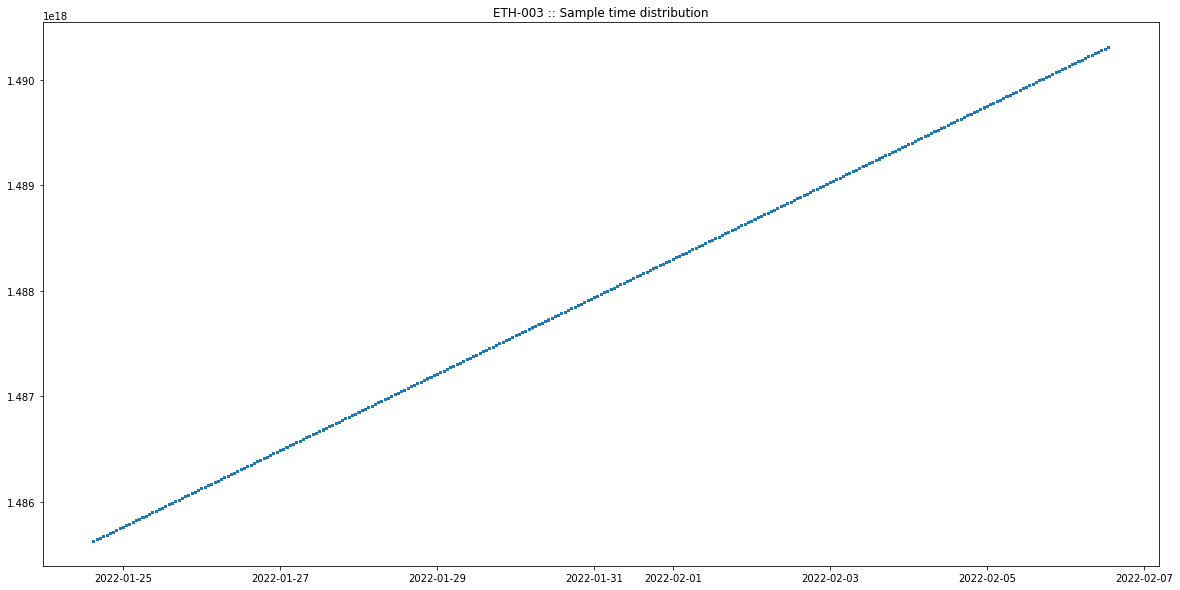

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

plt.scatter(pd.to_datetime(dfs[coin]['created_at']), dfs[coin]['id'], s=1)
plt.title(f"{coin}-{dataset} :: Sample time distribution")
plt.show()

In [6]:
import math
import warnings

batch_size = 100

sentiments = ['positive', 'negative', 'enthusiastic', 'confused', 'angry', 'sad',
              'greedy', 'fearful', 'shocked', 'hopeful', 'indifferent', 'sarcastic']

def classify(texts, sents):
    hypothesis_template = "This user is feeling {}."
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        result = classifier([f"The user said: \"{text}\"" for text in texts], sents, # num_workers=0 in Windows 10
                          multi_label=True, hypothesis_template=hypothesis_template, num_workers=0)
    return result

def process(df_orig, sents=sentiments):
    df = df_orig.copy()
    sent_data = {sent: [] for sent in sents}

    for i in trange(math.ceil(len(df) / batch_size), desc='Scoring sentiments...', ncols=100):
        batch = list(df['text'].iloc[i * batch_size : (i+1) * batch_size])
        for t in classify(batch, sents):
            for sent, score in zip(t['labels'], t['scores']):
                sent_data[sent].append(score)

    for sent in sents:
        df[f"sa/{sent}"] = sent_data[sent]
    
    return df

In [7]:
# dfs[coin] = process(dfs[coin], sents=sentiments)

Scoring sentiments...:   3%|█▏                                   | 10/311 [04:52<2:22:11, 28.34s/it]C:\Users\Agando\AppData\Roaming\Python\Python37\site-packages\transformers\pipelines\base.py:910: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Scoring sentiments...: 100%|████████████████████████████████████| 311/311 [2:28:42<00:00, 28.69s/it]


In [8]:
# dfs[coin].to_csv(f"s-analysis/{coin}-{dataset}.csv", index=False)

<hr>

## Create index

In [3]:
import glob

coin = 'ETH'

# load into dfs[coin] all files in "s-analysis/{coin}-*.csv" concatenated

df_arr = []
for filepath in glob.iglob(f"s-analysis/{coin}-*.csv"):
    print(filepath)
    df_arr.append(pd.read_csv(filepath))
    print(f"-> Last: {df_arr[-1]['created_at'].iloc[-1]}")
dfs[coin] = pd.concat(df_arr)

s-analysis\ETH-001.csv
-> Last: 2022-01-10T18:59:21.000Z
s-analysis\ETH-002.csv


c:\users\agando\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


-> Last: 2022-01-24T13:59:23.000Z
s-analysis\ETH-003.csv
-> Last: 2022-02-06T12:59:30.000Z
s-analysis\ETH-004.csv
-> Last: 2022-02-14T18:59:32.000Z


In [4]:
from datetime import datetime

# need to do this safely because of dirty data (1 in 60k)
def convert_to_hour_id(x):
    try:
        y = pd.to_datetime(x)
    except:
        y = datetime.fromtimestamp(int(x) // 10**9)
    return int(y.timestamp()) // 3600

df_w = dfs[coin][dfs[coin]['created_at'].notna()].copy().reset_index(drop=True)
df_w['hour_id'] = df_w['created_at'].map(convert_to_hour_id)

# drop if id was parsed wrongly
df_w.drop(df_w[df_w['id'].apply(lambda x: not str(x).isdigit())].index, inplace=True)

df_w

,id,text,author_id,retweets,replies,likes,quotes,created_at,orig_id,orig_created_at,...,sa/angry,sa/sad,sa/greedy,sa/fearful,sa/shocked,sa/hopeful,sa/indifferent,sa/sarcastic,orig_created_at\r,hour_id
0,1471283934046556162,"❄️Santa Apes are coming, to town ❄️\n\nTo cele...",1.434834e+18,208.0,0.0,0.0,0,2021-12-16T00:59:59.000Z,1.470936e+18,2021-12-15T01:58:08.000Z,...,0.017993,0.005559,0.678942,0.047965,0.496561,0.946727,0.002555,0.983641,NaN,455448
1,1471283933467668480,NY Times is racist paper sued 4 racial discrim...,8.354793e+17,46.0,0.0,0.0,0,2021-12-16T00:59:59.000Z,1.471114e+18,2021-12-15T13:46:34.000Z,...,0.999172,0.983607,0.456450,0.974669,0.995131,0.004060,0.520911,0.997612,NaN,455448
2,1471283932083621889,"Totoroman,SHIBLI’s first free to play,play to ...",1.442749e+18,430.0,0.0,0.0,0,2021-12-16T00:59:59.000Z,1.471246e+18,2021-12-15T22:28:08.000Z,...,0.054367,0.002846,0.513532,0.008347,0.813724,0.948593,0.002137,0.910517,NaN,455448
3,1471283931777581060,Do you believe #Dogezillacoin Can Go $0.000000...,1.462836e+18,173.0,0.0,0.0,0,2021-12-16T00:59:59.000Z,1.470884e+18,2021-12-14T22:32:36.000Z,...,0.131045,0.014268,0.293637,0.111793,0.955265,0.387245,0.003396,0.990682,NaN,455448
4,1471283931706454019,🌊 EternalFlow $EFT #BSC\n\n🚀 Up 5x in 5 Days\n...,2.337904e+09,1514.0,0.0,0.0,0,2021-12-16T00:59:59.000Z,1.471205e+18,2021-12-15T19:47:04.000Z,...,0.799912,0.484361,0.915235,0.080153,0.940179,0.957127,0.003726,0.971243,NaN,455448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190967,1493298885363707910,@newsforsocial always be in #bullish with blue...,1.471925e+18,2.0,0.0,0.0,0,2022-02-14T18:59:33.000Z,1.493159e+18,2022-02-14T09:43:42.000Z,...,0.967593,0.067492,0.991476,0.328056,0.930972,0.141010,0.008539,0.999381,NaN,456906
190968,1493298883857989644,@MEXC_Global Bluesparrow the future of the wo...,1.486788e+18,0.0,0.0,0.0,0,2022-02-14T18:59:32.000Z,NaN,NaN,...,0.015447,0.003371,0.298336,0.002030,0.745724,0.999590,0.002464,0.974919,NaN,456906
190969,1493298883790880768,@Tot_SamiyNFT ♥️ Michelle Rodriguez #26\n♥️ 0....,8.254473e+17,0.0,0.0,0.0,0,2022-02-14T18:59:32.000Z,NaN,NaN,...,0.014268,0.033495,0.395847,0.006808,0.495293,0.572435,0.007275,0.950407,NaN,456906
190970,1493298883342045188,@YesodWilliams no @CakedApes profile pic yet??...,1.455725e+18,0.0,0.0,2.0,0,2022-02-14T18:59:32.000Z,NaN,NaN,...,0.973487,0.798401,0.621187,0.785467,0.987844,0.022982,0.584109,0.990251,NaN,456906


No handles with labels found to put in legend.


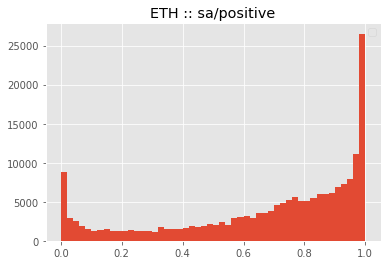

In [5]:
import matplotlib.pyplot as plt

sent = 'positive'
col = f"sa/{sent}"

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (6, 4)

dfs[coin][col].hist(bins=50)
plt.legend(loc='best')
plt.title(f"{coin} :: {col}")
plt.show()

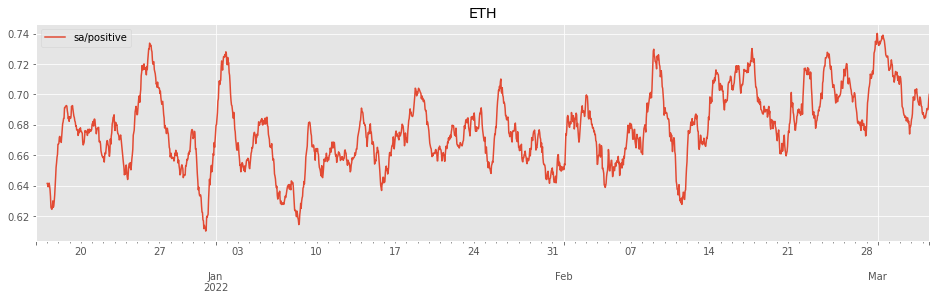

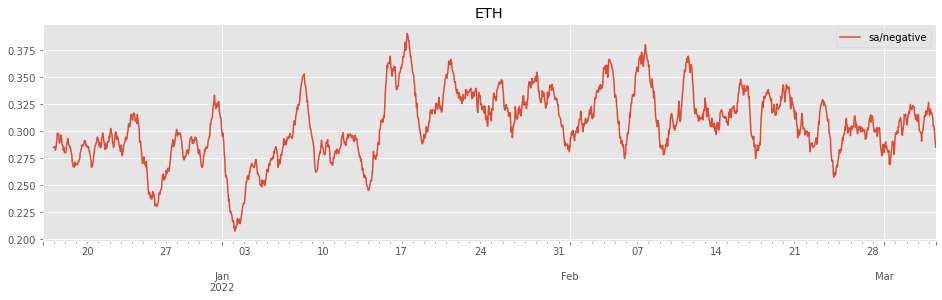

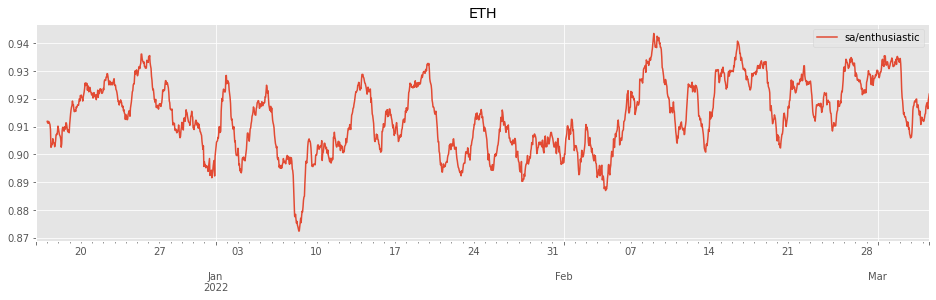

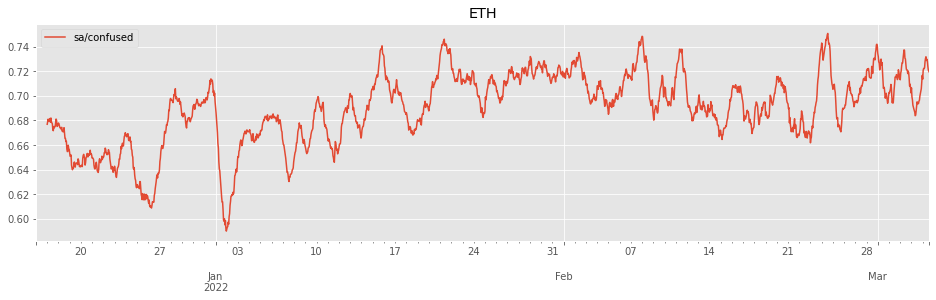

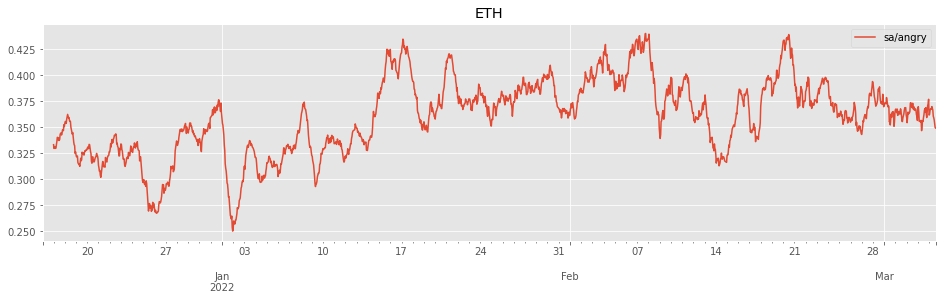

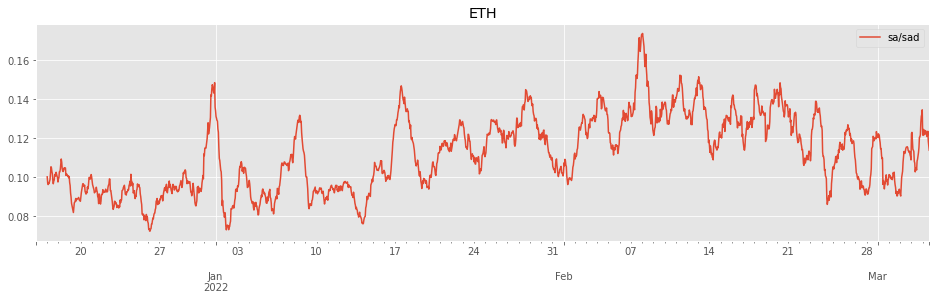

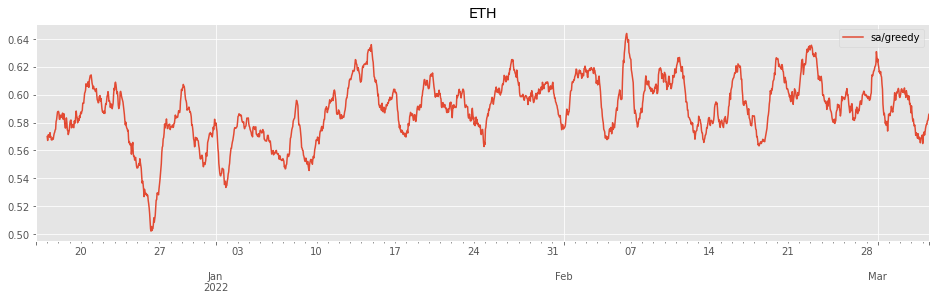

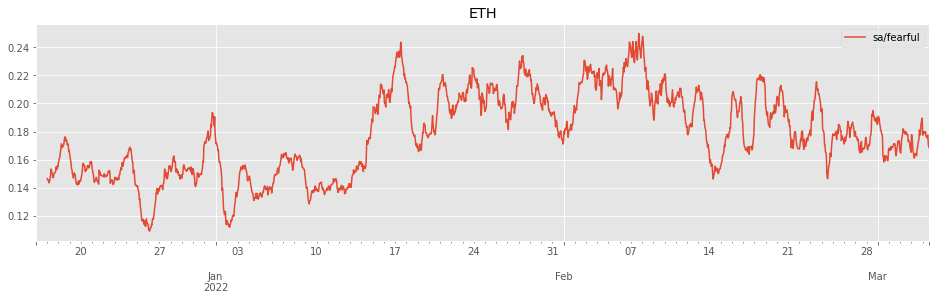

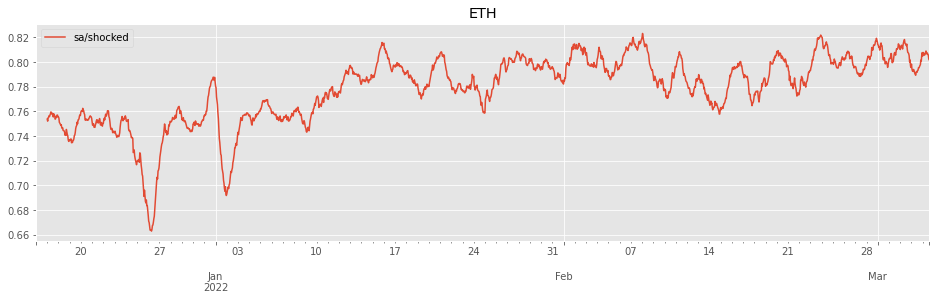

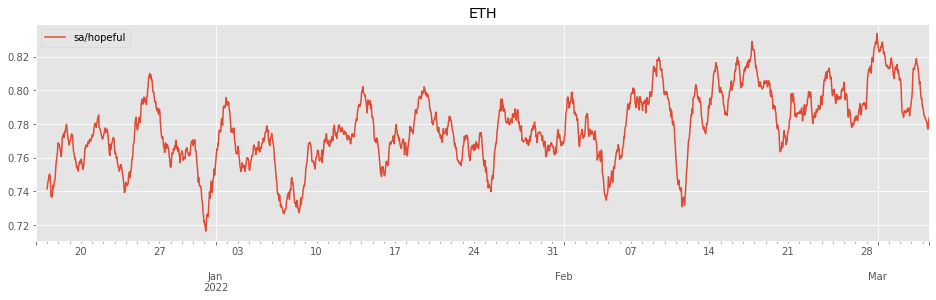

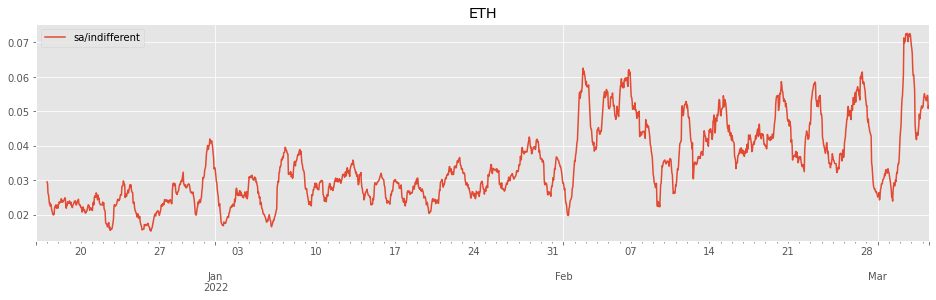

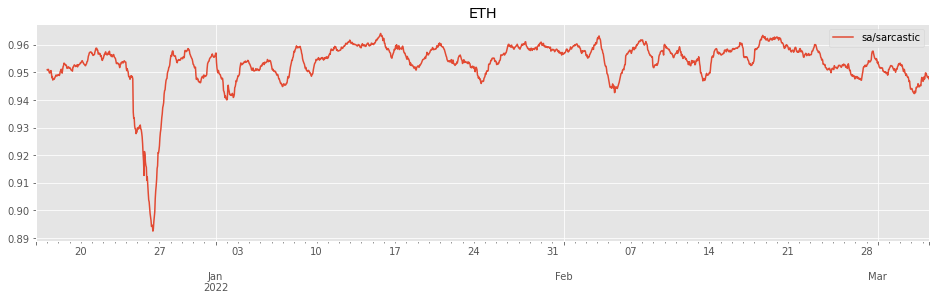

In [7]:
from datetime import timedelta

sentiments = ['positive', 'negative', 'enthusiastic', 'confused', 'angry', 'sad',
              'greedy', 'fearful', 'shocked', 'hopeful', 'indifferent', 'sarcastic']

sents = sentiments
dfi = {sent: {} for sent in sents}
dfi_agg = pd.DataFrame()

plt.rcParams["figure.figsize"] = (16, 4)

for sent in sents:
    col = f"sa/{sent}"
    dfi[sent] = pd.DataFrame(df_w.groupby('hour_id')[col].agg('mean'))
    dfi[sent]['dt'] = pd.to_datetime(dfi[sent].index * 3600 * 10**9) + timedelta(hours=1)
    dfi[sent] = dfi[sent].set_index('dt')
    ax1 = dfi[sent].rolling(window=24).mean().plot(title=f"{coin}")
    ax1.xaxis.label.set_visible(False)
    
    dfi_agg[sent] = dfi[sent][col]

In [8]:
dfi_agg

,positive,negative,enthusiastic,confused,angry,sad,greedy,fearful,shocked,hopeful,indifferent,sarcastic
dt,,,,,,,,,,,,
2021-12-16 01:00:00,0.673810,0.274815,0.911898,0.665413,0.365980,0.166250,0.628976,0.144655,0.784745,0.704155,0.038464,0.957746
2021-12-16 02:00:00,0.630111,0.310599,0.899425,0.683043,0.315813,0.115684,0.543920,0.168807,0.740179,0.739792,0.079180,0.953256
2021-12-16 03:00:00,0.596139,0.268445,0.905419,0.738646,0.381683,0.106439,0.579301,0.159367,0.760390,0.711168,0.043775,0.954440
2021-12-16 04:00:00,0.640802,0.326485,0.902738,0.725753,0.361586,0.101688,0.572307,0.180877,0.757447,0.713508,0.062789,0.961976
2021-12-16 05:00:00,0.715644,0.183719,0.932378,0.668086,0.290512,0.046942,0.592422,0.093922,0.762689,0.778356,0.045089,0.957027
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-05 10:00:00,0.699477,0.270420,0.907396,0.675583,0.356885,0.097501,0.644934,0.206093,0.843509,0.771747,0.047545,0.944483
2022-03-05 11:00:00,0.714571,0.260296,0.907551,0.707802,0.312341,0.151819,0.625415,0.198918,0.794192,0.781232,0.038344,0.949226
2022-03-05 12:00:00,0.686815,0.232429,0.928757,0.681844,0.331886,0.070329,0.584095,0.091620,0.776603,0.828554,0.013158,0.945351


In [9]:
dfi_agg.to_csv(f"s-analysis/indices-{coin}-{dataset}.csv", index=True)

In [14]:
import sys; sys.executable.replace('\\', '/')

'c:/users/agando/appdata/local/programs/python/python37/python.exe'